# No Mixture, Simple Alternation

Notice that AlternatingManifoldHMC is **time-inhomogeneous** because at odd steps we use the HMC kernel whereas at even steps we use the Zappa one.

This version considers the case in which we alternate $1$ HMC step with $m$ Zappa steps. We perform $n$ HMC steps so that the total number of samples is given by $nm$

### Settings and Algorithm Run

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import multivariate_normal, norm
from gaussian_hmc import GaussianTargetHMC
from zappa import zappa_sampling
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import logf, logp
import matplotlib.pyplot as plt
from alternating_manifoldhmc import AlternatingManifoldHMC

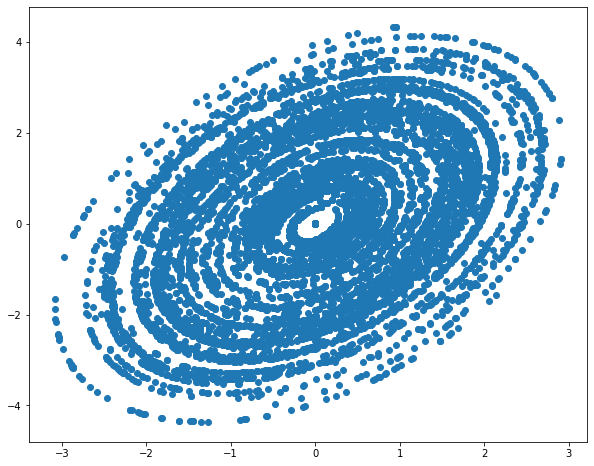

In [3]:
# Settings
Sigma = np.array([[1.0, 0.6], [0.6, 2.0]])  # Covariance Matrix of Target Distribution
mu = np.zeros(2)                            # Mean of target distribution
N = 10000                                   # Total number of samples
n = 1                                       # HMC steps per iteration
m = 100                                     # Number of Zappa samples per each HMC sample
T = 5                                       # Total integration time
epsilon = 0.05                              # Step size
M = np.eye(2)                               # Coviariance Matrix for momentum distribution
s = 1.0


# Target distribution
target = multivariate_normal(mean=mu, cov=Sigma)

# Sample and plot
x0 = target.rvs()
samples = AlternatingManifoldHMC(x0, N=N, n=n, m=m, Sigma=Sigma, mu=mu, T=T, epsilon=epsilon, M=M, s=s)
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(samples[:, 0], samples[:,1])
plt.show()

### Check convergence

In [4]:
np.cov(samples.T)

array([[1.37099837, 0.95867428],
       [0.95867428, 3.11275565]])

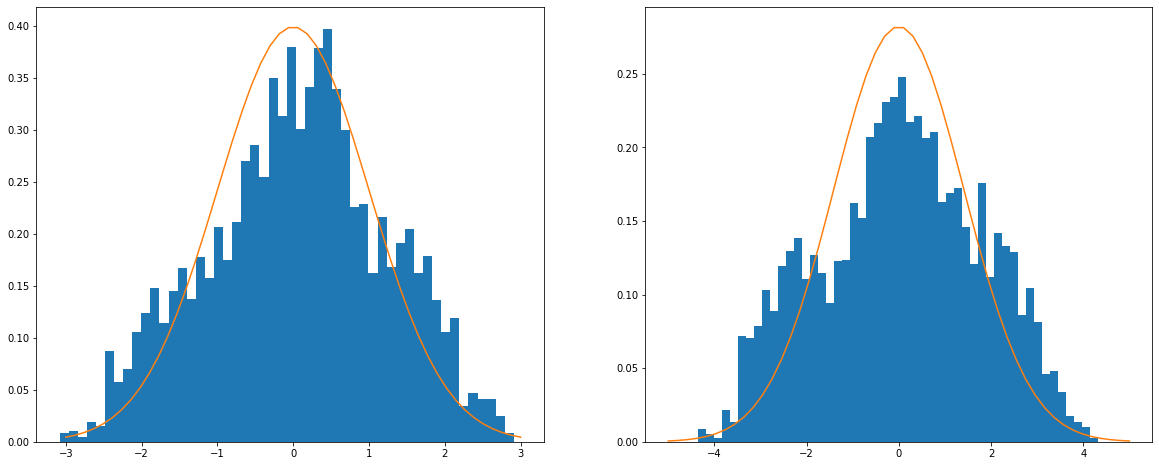

In [5]:
# marginals
marginal_x = norm(loc=mu[0], scale=np.sqrt(Sigma[0,0]))
marginal_y = norm(loc=mu[1], scale=np.sqrt(Sigma[1,1]))

# Plotting vars
xs = np.linspace(-3, 3)
ys = np.linspace(-5, 5)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

# X space
_ = ax[0].hist(samples[:, 0], bins=50, density=True)
ax[0].plot(xs, marginal_x.pdf(xs))

# Y space
_ = ax[1].hist(samples[:, 1], bins=50, density=True)
ax[1].plot(ys, marginal_y.pdf(ys))

plt.show()

### Short Run to Examine Behavior

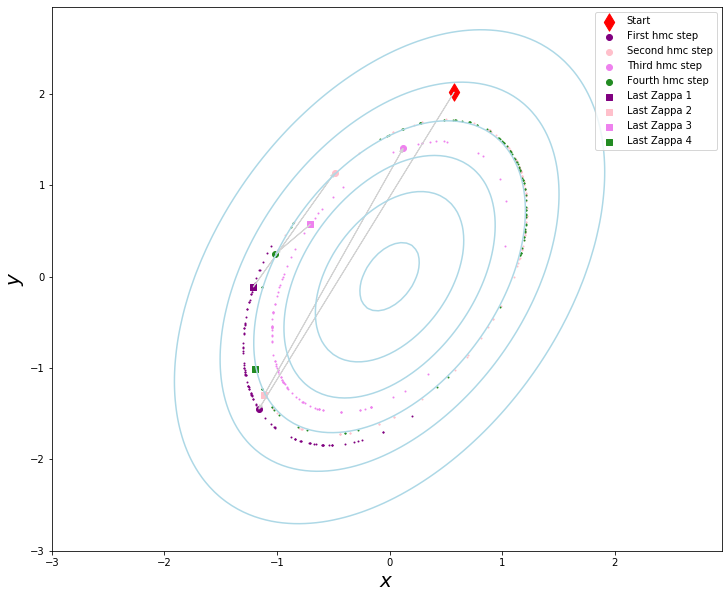

In [6]:
# Starting point
x0 = target.rvs()

# HMC - Step 1
x_hmc1 = GaussianTargetHMC(q0=x0, n=1, M=M, T=T, epsilon=epsilon, Sigma=Sigma, mu=mu).sample()[-1]
z1 = target.pdf(x_hmc1)

# Zappa - Step 1
zappa1 = zappa_sampling(
    x_hmc1, 
    RotatedEllipse(mu, Sigma, z1), 
    logf, logp, 100, 0.5, 1.48e-08, 1.0
)
x1 = zappa1[-1]

# HMC - Step 2
x_hmc2 = GaussianTargetHMC(q0=x1, n=1, M=M, T=T, epsilon=epsilon, Sigma=Sigma, mu=mu).sample()[-1]
z2 = target.pdf(x_hmc2)

# Zappa - Step 2 
zappa2 = zappa_sampling(
    x_hmc2, 
    RotatedEllipse(mu, Sigma, z2), 
    logf, logp, 100, 0.5, 1.48e-08, 1.0
)
x2 = zappa2[-1]

# HMC - Step 3
x_hmc3 = GaussianTargetHMC(q0=x2, n=1, M=M, T=T, epsilon=epsilon, Sigma=Sigma, mu=mu).sample()[-1]
z3 = target.pdf(x_hmc3)

# Zappa - Step 3
zappa3 = zappa_sampling(
    x_hmc3, 
    RotatedEllipse(mu, Sigma, z3), 
    logf, logp, 100, 0.5, 1.48e-08, 1.0
)
x3 = zappa3[-1]

# HMC - Step 4
x_hmc4 = GaussianTargetHMC(q0=x3, n=1, M=M, T=T, epsilon=epsilon, Sigma=Sigma, mu=mu).sample()[-1]
z4 = target.pdf(x_hmc4)

# Zappa - Step 4
zappa4 = zappa_sampling(
    x_hmc4, 
    RotatedEllipse(mu, Sigma, z4), 
    logf, logp, 100, 0.5, 1.48e-08, 1.0
)
x4 = zappa4[-1]



# PLOTTING
xmin, xmax, xstep = -3, 3, 0.05
ymin, ymax, ystep = -3, 3, 0.05
x_grid, y_grid = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]
contour_values = target.pdf(np.dstack((x_grid, y_grid)))

fig, ax = plt.subplots(figsize=(12, 10))
# Start
ax.scatter(*x0, label="Start", color="red", marker='d', s=150)
# HMC steps
ax.scatter(*x_hmc1, label="First hmc step", color="purple")
ax.scatter(*x_hmc2, label="Second hmc step", color="pink")
ax.scatter(*x_hmc3, label="Third hmc step", color="violet")
ax.scatter(*x_hmc4, label="Fourth hmc step", color="forestgreen")
# Contour
ax.contour(x_grid, y_grid, contour_values, colors="lightblue")
# Zappa Steps
ax.scatter(zappa1[:, 0], zappa1[:, 1], color="purple", s=1)
ax.scatter(zappa2[:, 0], zappa2[:, 1], color="pink", s=1)
ax.scatter(zappa3[:, 0], zappa3[:, 1], color="violet", s=1)
ax.scatter(zappa4[:, 0], zappa4[:, 1], color="forestgreen", s=1)
# End of Zappa
ax.scatter(*x1, label="Last Zappa 1", marker='s', color="purple")
ax.scatter(*x2, label="Last Zappa 2", marker='s', color="pink")
ax.scatter(*x3, label="Last Zappa 3", marker='s', color="violet")
ax.scatter(*x4, label="Last Zappa 4", marker='s', color="forestgreen")
# Arrows
ax.arrow(*x0, *(x_hmc1-x0), length_includes_head=True, head_width=0.03, color="lightgray")
ax.arrow(*x1, *(x_hmc2-x1), length_includes_head=True, head_width=0.03, color="lightgray")
ax.arrow(*x2, *(x_hmc3-x2), length_includes_head=True, head_width=0.03, color="lightgray")
ax.arrow(*x3, *(x_hmc4-x3), length_includes_head=True, head_width=0.03, color="lightgray")
# Prettify
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
plt.legend()
plt.show()